In [36]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [37]:
torch.cuda.is_available()

True

In [38]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


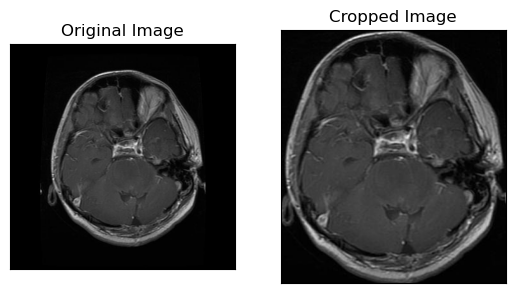

In [39]:
import cv2
ex_img = cv2.imread('brain tumor 2/Testing/glioma/test g (1).jpg')
print(ex_img)
ex_new_img = crop_brain_contour(ex_img, True)

In [40]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [41]:
Training = r'brain tumor 2\Training\glioma'
Testing =r'brain tumor 2\Testing\glioma'
IMG_WIDTH, IMG_HEIGHT = (240,240)
X, y = load_data([Training,Testing],(IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1621
X shape is: (1621, 240, 240, 3)
y shape is: (1621, 1)


In [42]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

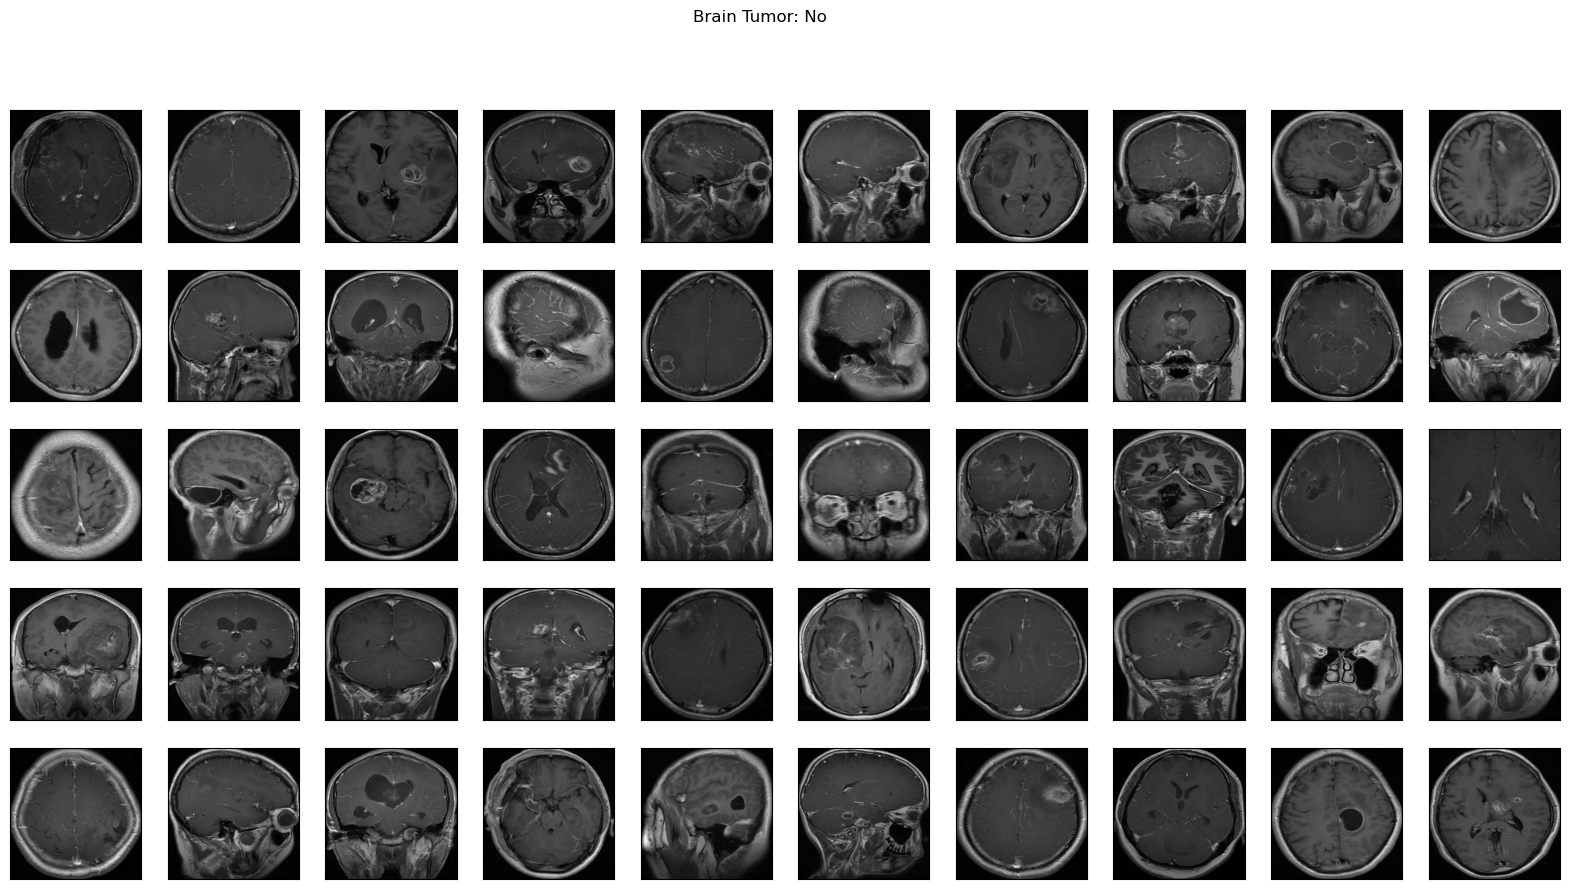

<Figure size 2000x1000 with 0 Axes>

In [43]:
plot_sample_images(X, y)

In [44]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    # X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [46]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [47]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [49]:

class BTD(nn.Module):
    def __init__(self):
        super(BTD, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=4)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.dense = nn.Linear(13 * 13 * 64, 512) 
        self.relu3 = nn.ReLU()
        self.dense2 = nn.Linear(512,10)

    def forward(self, x):
        # x = nn.ZeroPad2d((2, 2, 2, 2))(x)  # Padding to make (244, 244, 3)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool1(x)  # Reduce to (59, 59, 32)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)  # Reduce to (14, 14, 32)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dense(x)
        x = self.relu3(x)
        x = self.dense2(x)
        return x
    
def inner_loop(model, criterion, optimizer, support_set, query_set):
    # Inner loop for few-shot learning using MAML
    for inputs, labels in support_set:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in query_set:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# Testing the network architecture
model = BTD()
print(model)


BTD(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense): Linear(in_features=10816, out_features=512, bias=True)
  (relu3): ReLU()
  (dense2): Linear(in_features=512, out_features=10, bias=True)
)


Epoch [1/20], Loss: 0.3397, Train Accuracy: 86.66%, Validation Accuracy: 89.90%
Epoch [2/20], Loss: 0.3025, Train Accuracy: 88.03%, Validation Accuracy: 84.40%
Epoch [3/20], Loss: 0.2943, Train Accuracy: 88.55%, Validation Accuracy: 91.49%
Epoch [4/20], Loss: 0.2556, Train Accuracy: 90.18%, Validation Accuracy: 92.87%
Epoch [5/20], Loss: 0.2212, Train Accuracy: 91.26%, Validation Accuracy: 93.10%
Epoch [6/20], Loss: 0.2113, Train Accuracy: 92.05%, Validation Accuracy: 92.33%
Epoch [7/20], Loss: 0.2210, Train Accuracy: 91.61%, Validation Accuracy: 83.30%
Epoch [8/20], Loss: 0.1912, Train Accuracy: 93.01%, Validation Accuracy: 89.57%
Epoch [9/20], Loss: 0.1781, Train Accuracy: 93.43%, Validation Accuracy: 85.70%
Epoch [10/20], Loss: 0.1654, Train Accuracy: 94.00%, Validation Accuracy: 92.58%
Epoch [11/20], Loss: 0.1430, Train Accuracy: 94.66%, Validation Accuracy: 96.10%
Epoch [12/20], Loss: 0.1414, Train Accuracy: 94.73%, Validation Accuracy: 94.42%
Epoch [13/20], Loss: 0.1399, Train Ac

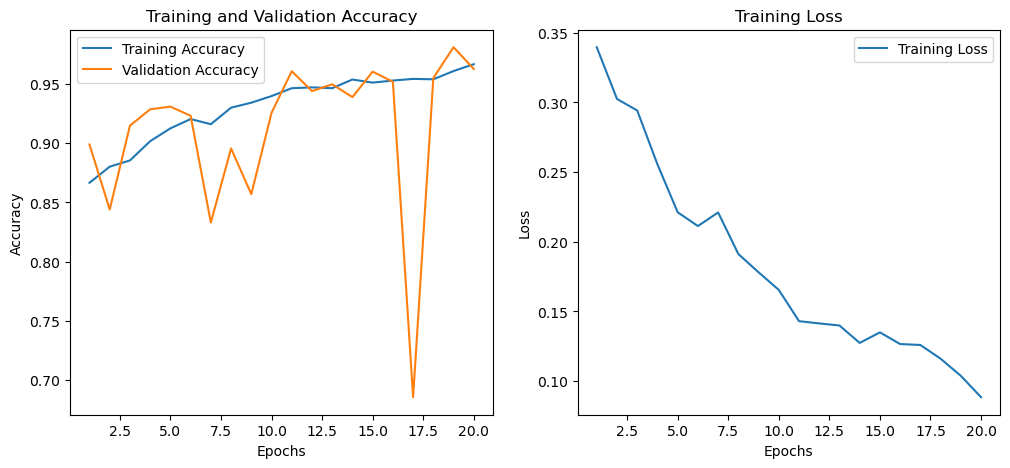

In [53]:
# Define loss function and optimizer
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models


# Set batch size and number of epochs
batch_size = 32


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

# Define paths to your 'yes' and 'no' data folders
train_data_path = r'D:\07 project\04 BTD pytorch\brain tumor 2\Training'
test_data_path = r'D:\07 project\04 BTD pytorch\brain tumor 2\Testing'

# Load data using ImageFolder
train_dataset = ImageFolder(root=train_data_path, transform=transform)
test_dataset = ImageFolder(root=test_data_path, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

train_acc_history = []
val_acc_history = []
loss_history = []

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Calculate training accuracy and loss
    train_accuracy = correct_train / total_train
    train_acc_history.append(train_accuracy)
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = correct_val / total_val
    val_acc_history.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, Validation Accuracy: {val_accuracy*100:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_acc_history, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.show()



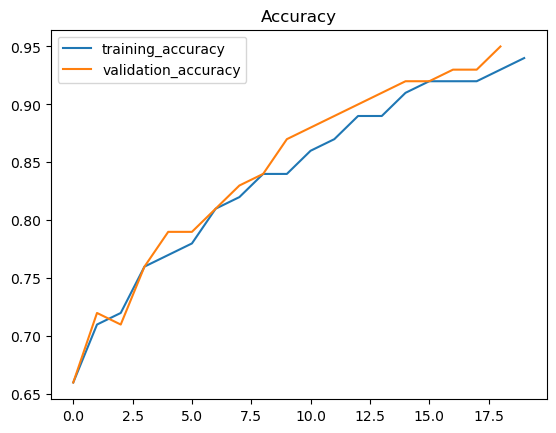

In [ ]:
training_accuracy = [0.66,0.71,0.72, 0.76, 0.77, 0.78, 0.81,0.82, 0.84,0.84, 0.86,0.87,0.89,0.89,0.91,0.92,0.92,0.92,0.93,0.94]
validation_accuracy = [0.66,0.72,0.71,0.76,0.79,0.79,0.81,0.83,0.84,0.87,0.88,0.89,0.90,0.91,0.92,0.92,0.93,0.93,0.95]

plt.plot(training_accuracy, label="training_accuracy")
plt.plot(validation_accuracy,label="validation_accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()
